# TPCH Overall Visualization

This notebook consolidates TPCH benchmark results across scales and queries.
It auto-detects the latest result directory for each `(scale, query)` pair under
`results/`, aggregates them into per-scale and per-query DataFrames, and then
produces publication-ready figures.

- **Per scale**: compare engines/layouts within the same scale.
- **Per query**: compare how a fixed TPCH query behaves as the scale changes.
- **Violin overview**: optional aggregate distribution across all scales.

All plots are saved under `viz_out_results/tpch_overall/` for convenient export.


In [1]:
# --- Bootstrap: allow importing project modules ---
import sys
import matplotlib.pyplot as plt
from pathlib import Path

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

NB_DIR = Path.cwd()
PROJ_ROOT = NB_DIR.parent

for path in (NB_DIR, PROJ_ROOT):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

import pandas as pd
from collections import defaultdict
from viz_results_toolkit import (
    load_results_dir,
    plot_box,
    plot_violin,
    savefig_multi,
)


In [2]:
# Inspect available TPCH result runs (latest timestamp per scale/query)
results_root = PROJ_ROOT / "results"
latest_runs = defaultdict(dict)

for combo_dir in sorted(results_root.glob("tpch_*_Q*")):
    parts = combo_dir.name.split("_")
    if len(parts) < 3:
        continue
    scale = parts[1]
    query = parts[2].upper()
    timestamp_dirs = sorted([p for p in combo_dir.iterdir() if p.is_dir()])
    if timestamp_dirs:
        latest_runs[scale][query] = timestamp_dirs[-1]

if not latest_runs:
    raise SystemExit("No TPCH results found under results/; run benchmarks first.")

print("Found latest runs:")
for scale in sorted(latest_runs, key=lambda x: int(x)):
    queries = latest_runs[scale]
    entries = ", ".join(f"{q} -> {p.name}" for q, p in sorted(queries.items()))
    print(f"  scale={scale}: {entries}")


Found latest runs:
  scale=1: Q1 -> final, Q2 -> final, Q3 -> final, Q4 -> final, Q5 -> final, Q6 -> final, Q7 -> final
  scale=4: Q1 -> final, Q2 -> final, Q3 -> final, Q4 -> final, Q5 -> final, Q6 -> final, Q7 -> final
  scale=16: Q1 -> final, Q2 -> final, Q3 -> final, Q4 -> final, Q5 -> final, Q6 -> final, Q7 -> final
  scale=64: Q1 -> final, Q2 -> final, Q3 -> final, Q4 -> final, Q5 -> final, Q6 -> final, Q7 -> final


In [3]:
# Build aggregated DataFrames per scale and per query
from itertools import chain

scale_frames = {}
query_frames = defaultdict(list)
all_frames = []

for scale, qmap in latest_runs.items():
    scale_dfs = []
    for query, run_dir in qmap.items():
        df = load_results_dir(run_dir)
        df = df.copy()
        df["scale"] = int(scale)
        df["scale_str"] = scale
        df["query"] = df.get("query", query)
        df["query_group"] = query
        df["run_dir"] = str(run_dir)
        scale_dfs.append(df)
        query_frames[query].append(df)
        all_frames.append(df)
    if scale_dfs:
        scale_frames[scale] = pd.concat(scale_dfs, ignore_index=True)

for query, dfs in list(query_frames.items()):
    query_frames[query] = pd.concat(dfs, ignore_index=True)

available_metrics = sorted(set(chain.from_iterable(df.columns for df in scale_frames.values())))
print("Aggregated scales:", {k: len(v) for k, v in scale_frames.items()})
print("Aggregated queries:", {k: len(v) for k, v in query_frames.items()})
print("Available metrics (subset):", available_metrics[:10], "...")

OUTPUT_ROOT = PROJ_ROOT / "viz_out_results" / "tpch_overall"
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

candidate_metrics = [
    "elapsedTime_s",
    "executorRunTime_s",
    "executorCpuTime_s",
    "bytesRead_ev",
    "files_scanned",
]
metrics_present = [
    metric for metric in candidate_metrics
    if any(metric in df.columns for df in scale_frames.values())
]
print("Metrics to plot:", metrics_present)


Aggregated scales: {'16': 210, '1': 700, '4': 700, '64': 700}
Aggregated queries: {'Q1': 330, 'Q2': 330, 'Q3': 330, 'Q4': 330, 'Q5': 330, 'Q6': 330, 'Q7': 330}
Available metrics (subset): ['bytesRead', 'bytesRead_ev', 'bytes_input_files', 'bytes_scanned', 'bytes_scanned_ev', 'elapsedTime_s', 'engine', 'executorCpuTime_s', 'executorCpuTime_s_ev', 'executorRunTime_s'] ...
Metrics to plot: ['elapsedTime_s', 'executorRunTime_s', 'executorCpuTime_s', 'bytesRead_ev', 'files_scanned']


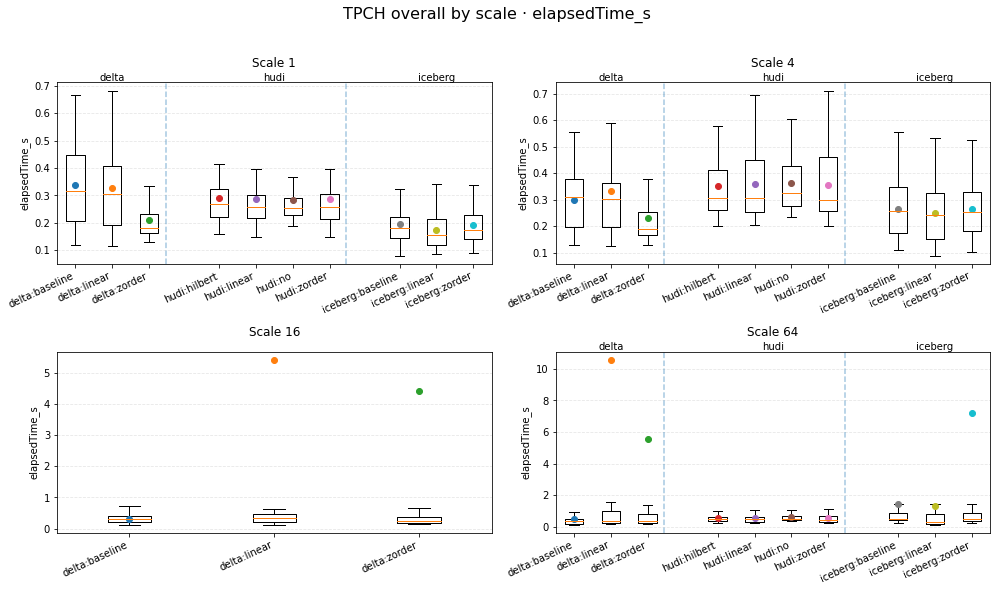

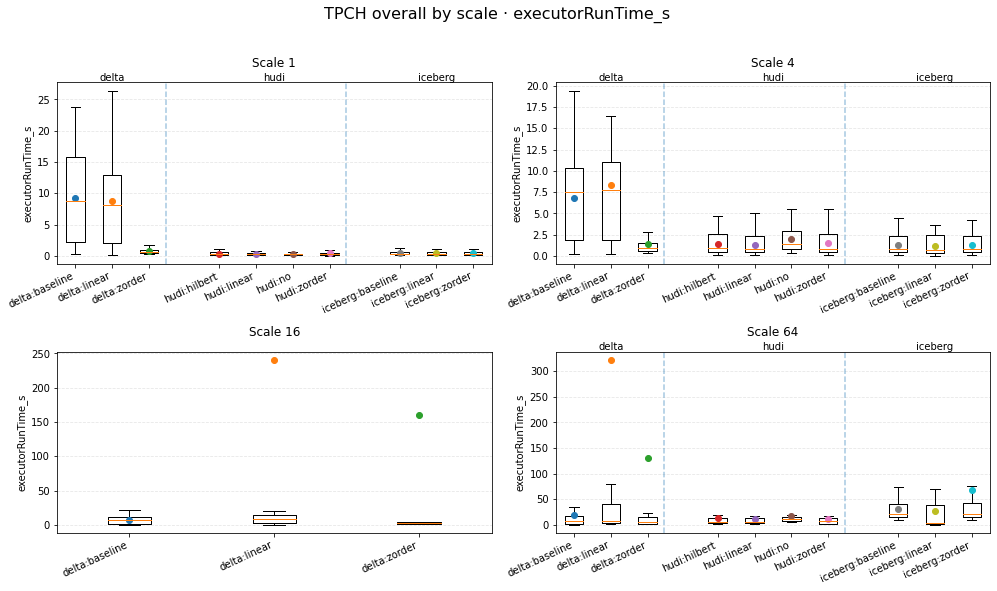

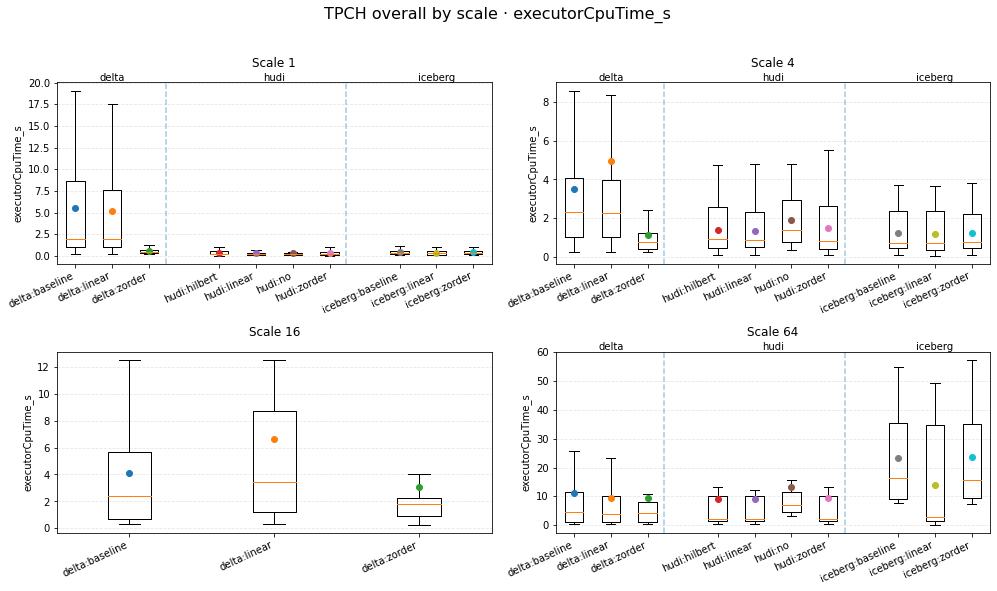

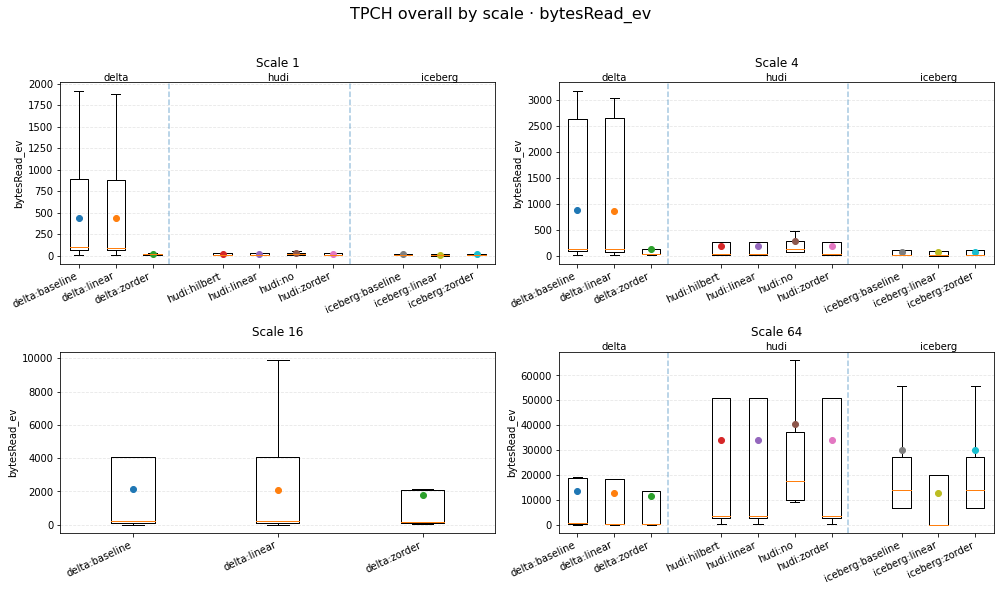

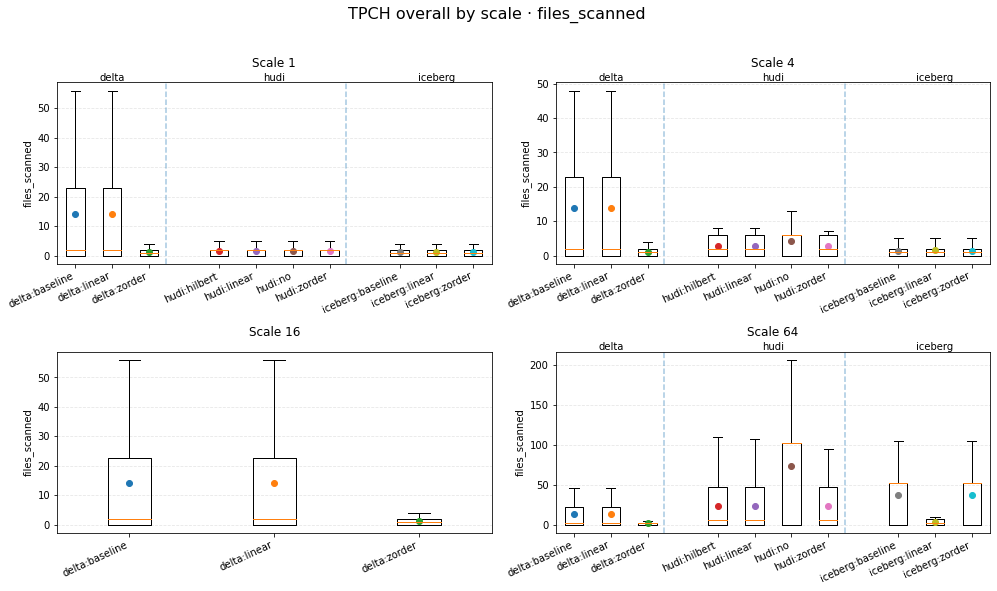

In [4]:
# Plot per scale: compare engines/layouts for each TPCH scale
if metrics_present:
    scale_order = sorted(scale_frames, key=lambda s: int(s))
    blocks_order = ("delta", "hudi", "iceberg")
    for metric in metrics_present:
        n = len(scale_order)
        ncols = 2 if n > 2 else n
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), squeeze=False)
        for idx, scale in enumerate(scale_order):
            r, c = divmod(idx, ncols)
            ax = axes[r][c]
            df_scale = scale_frames[scale]
            try:
                plot_box(
                    df_scale,
                    metric=metric,
                    group_cols=("engine", "layout"),
                    title=f"Scale {scale}",
                    ax=ax,
                    block_col="engine",
                    blocks_order=blocks_order,
                    block_gap=0.9,
                )
            except KeyError:
                ax.text(0.5, 0.5, f"Missing metric {metric}", ha="center", va="center")
                ax.axis("off")
        for k in range(len(scale_order), nrows * ncols):
            r, c = divmod(k, ncols)
            axes[r][c].axis("off")
        fig.suptitle(f"TPCH overall by scale · {metric}", y=1.02, fontsize=16)
        fig.tight_layout()
        savefig_multi(fig, OUTPUT_ROOT / f"scale_{metric}")
else:
    print("No metrics available for scale plots.")


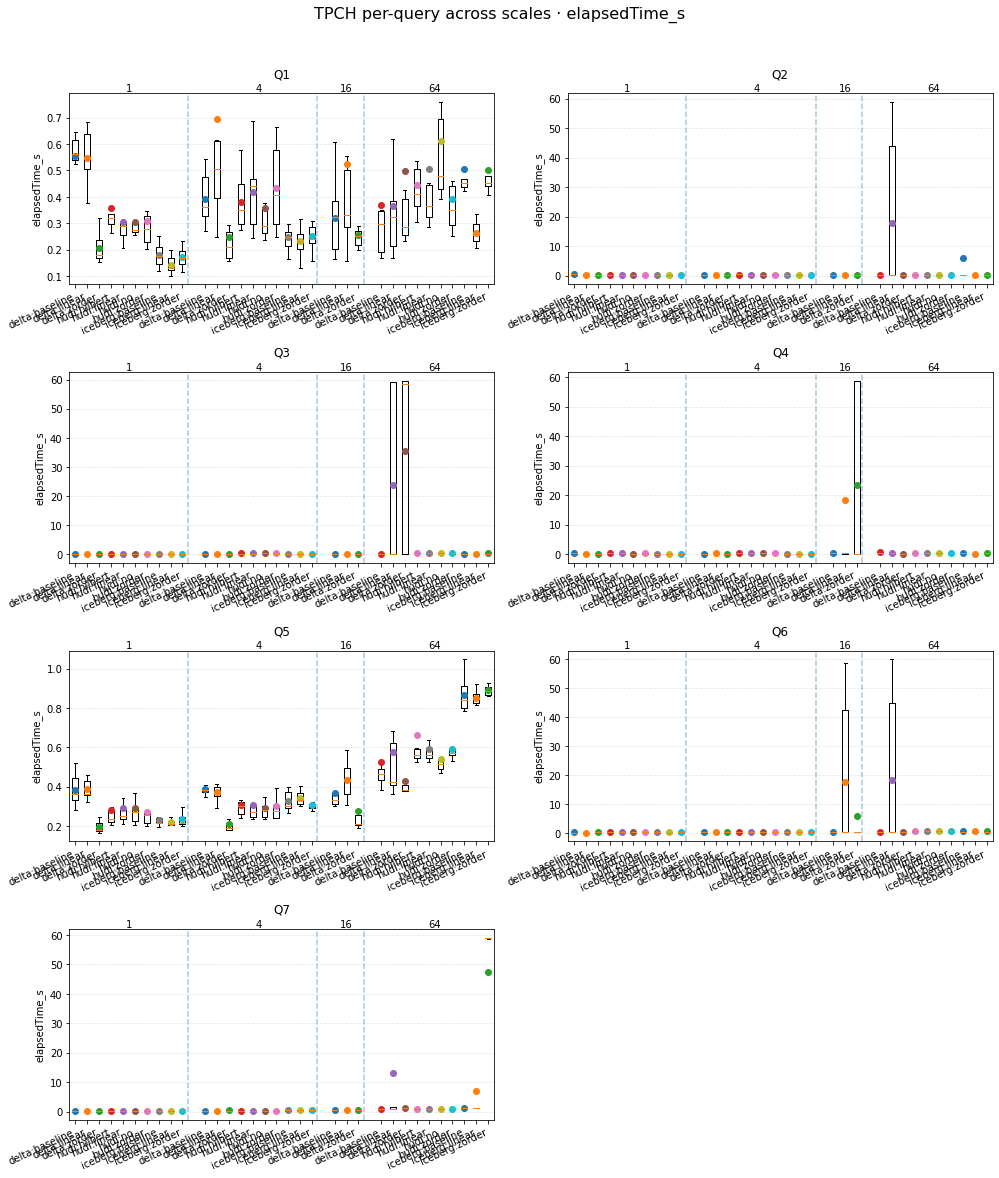

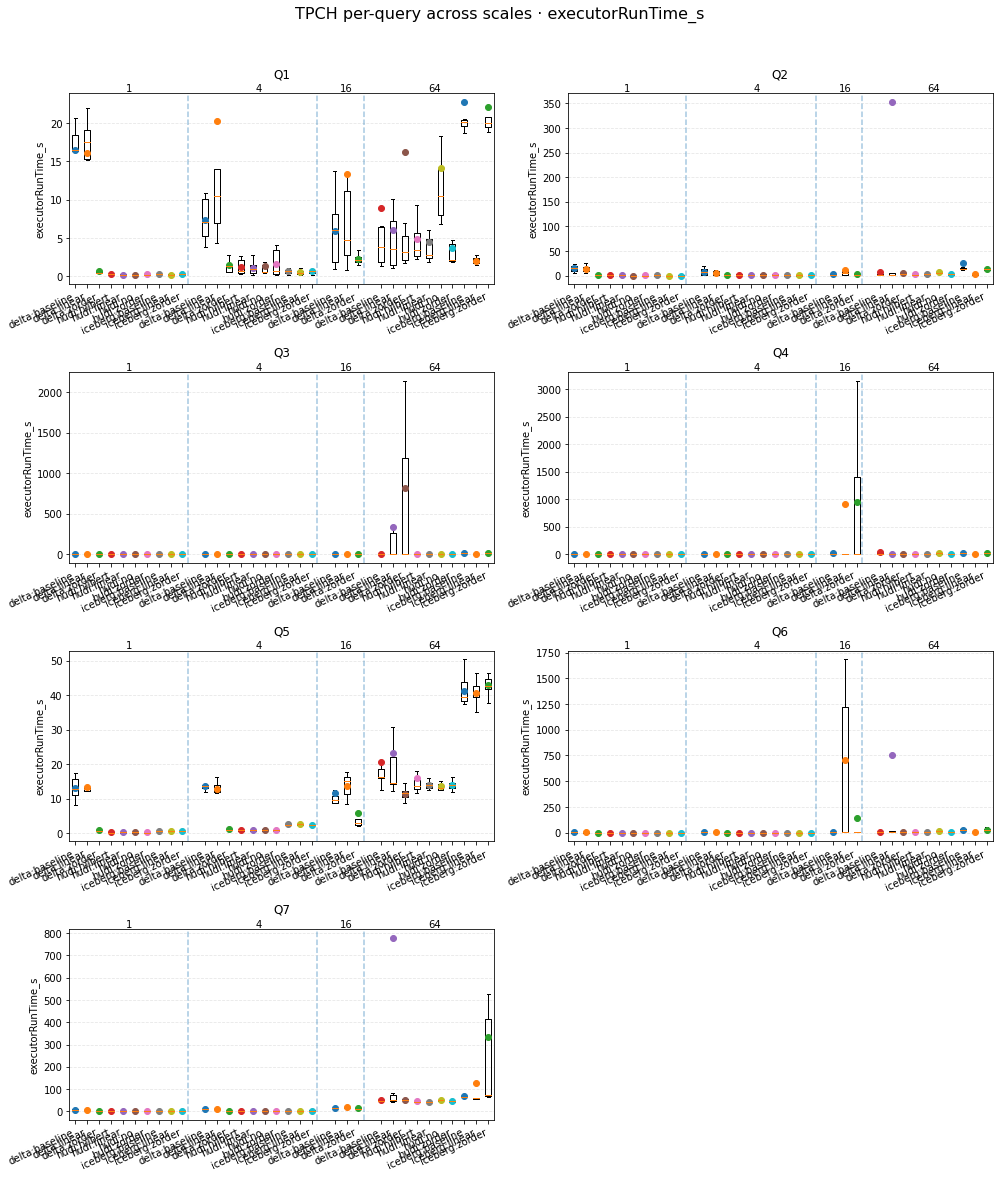

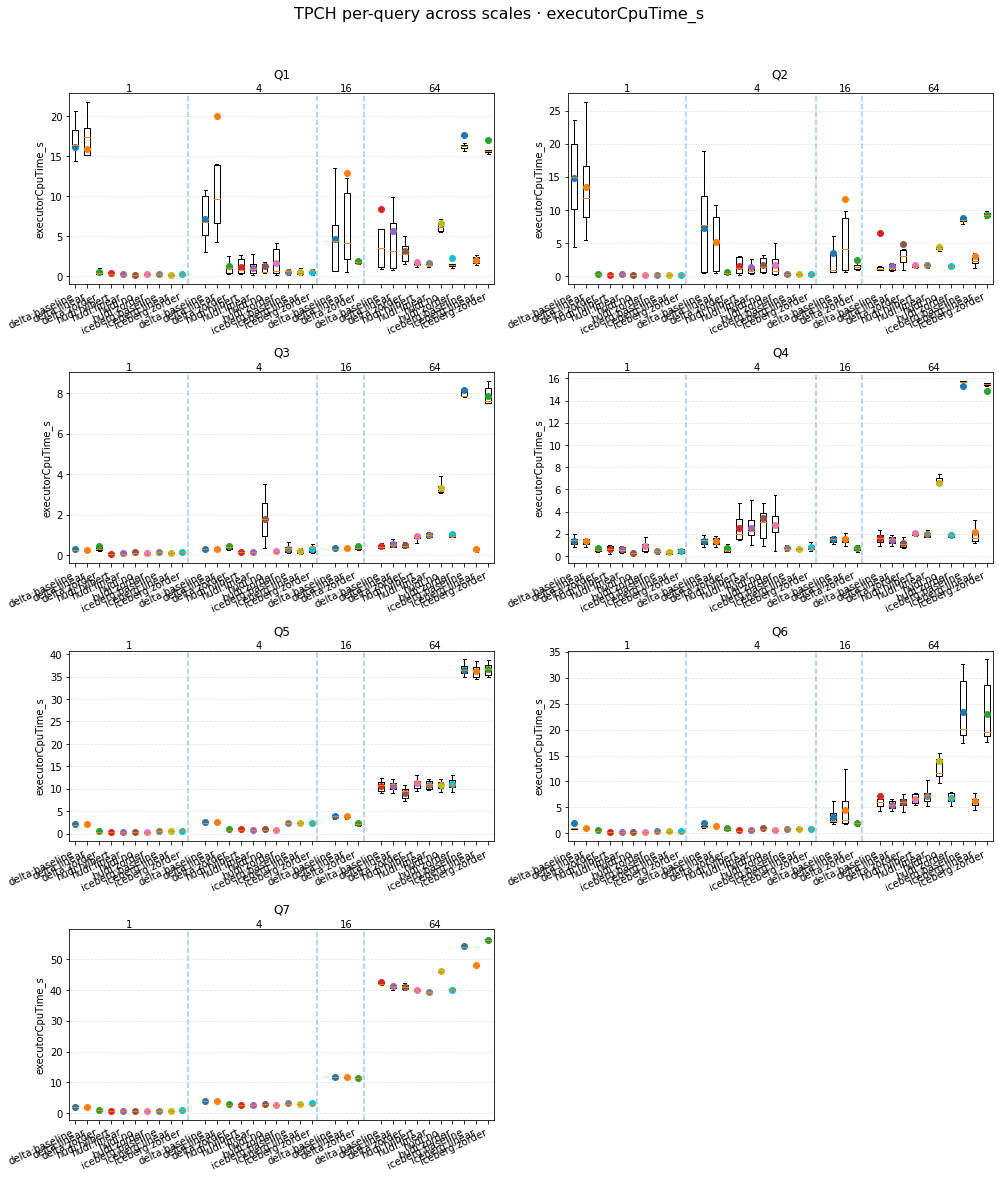

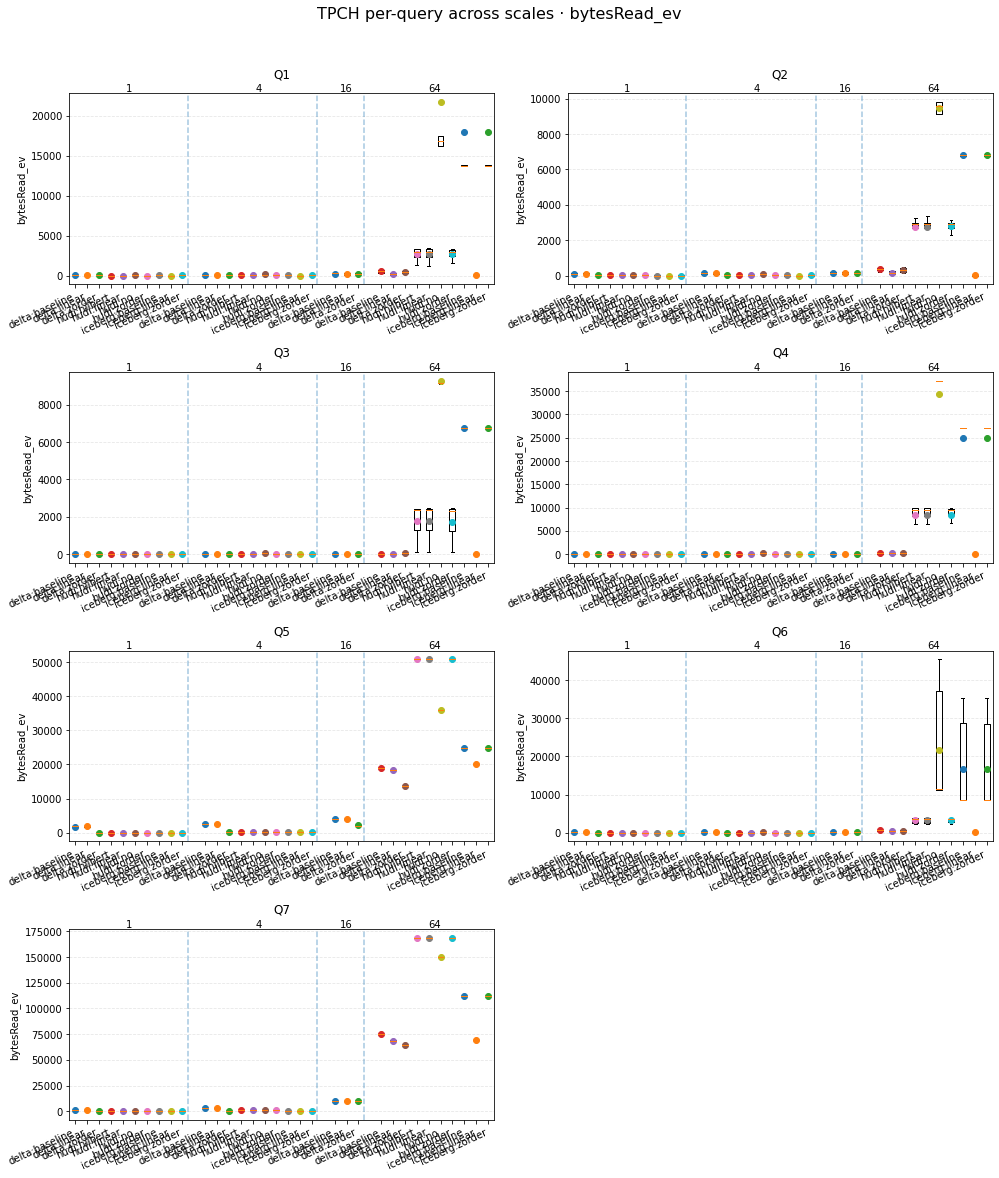

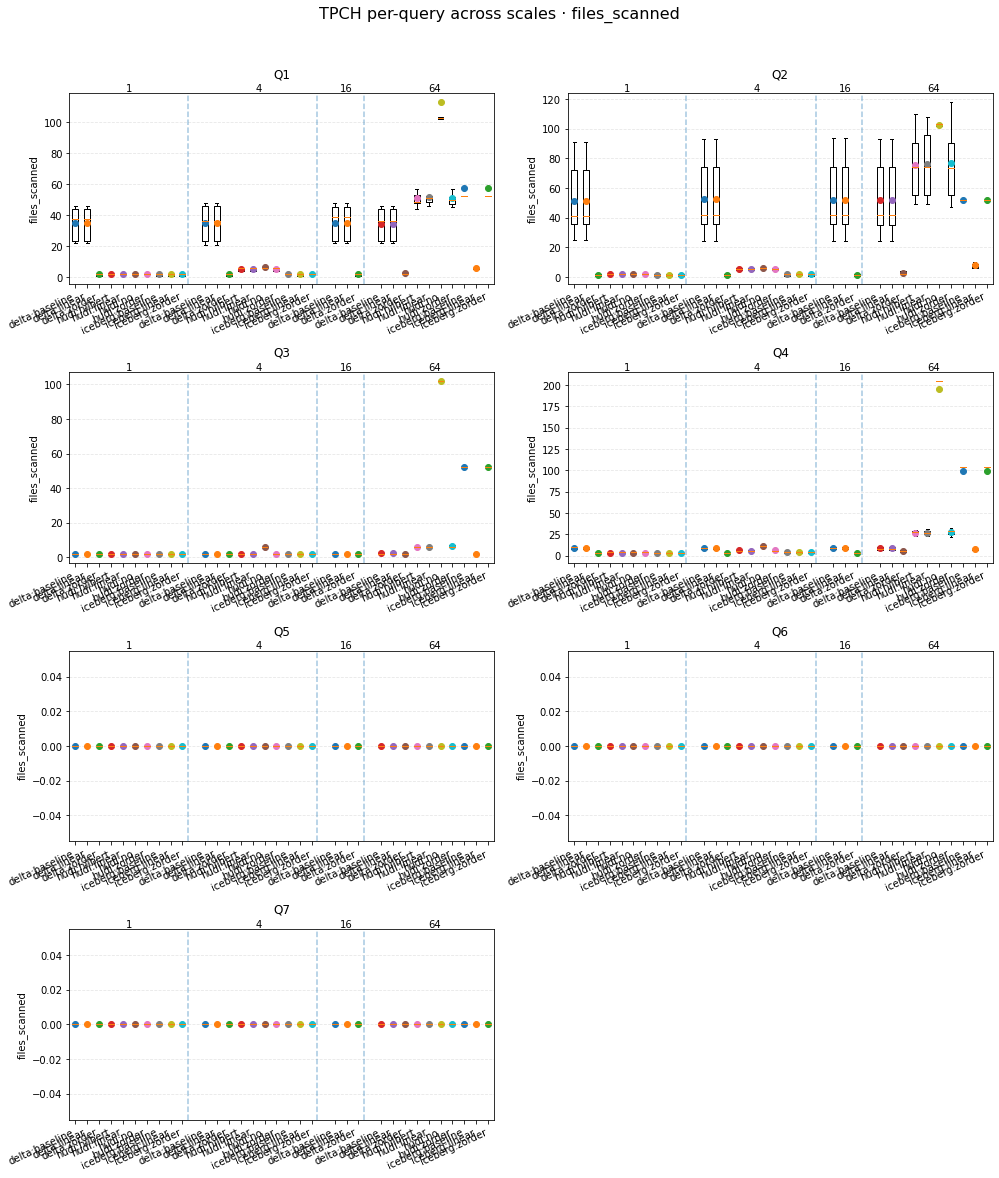

In [5]:
# Plot per query: compare scales for each TPCH query
if metrics_present:
    scale_order = sorted(scale_frames, key=lambda s: int(s))
    query_order = sorted(query_frames, key=lambda q: int(q[1:]) if q[1:].isdigit() else q)
    for metric in metrics_present:
        n = len(query_order)
        if n == 0:
            continue
        ncols = 2 if n > 2 else n
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), squeeze=False)
        for idx, query in enumerate(query_order):
            r, c = divmod(idx, ncols)
            ax = axes[r][c]
            dfq = query_frames[query].copy()
            dfq["scale_str"] = dfq["scale"].astype(str)
            try:
                plot_box(
                    dfq,
                    metric=metric,
                    group_cols=("engine", "layout"),
                    title=query,
                    ax=ax,
                    block_col="scale_str",
                    blocks_order=scale_order,
                    block_gap=0.9,
                )
            except KeyError:
                ax.text(0.5, 0.5, f"Missing metric {metric}", ha="center", va="center")
                ax.axis("off")
        for k in range(len(query_order), nrows * ncols):
            r, c = divmod(k, ncols)
            axes[r][c].axis("off")
        fig.suptitle(f"TPCH per-query across scales · {metric}", y=1.02, fontsize=16)
        fig.tight_layout()
        savefig_multi(fig, OUTPUT_ROOT / f"query_{metric}")
else:
    print("No metrics available for query plots.")


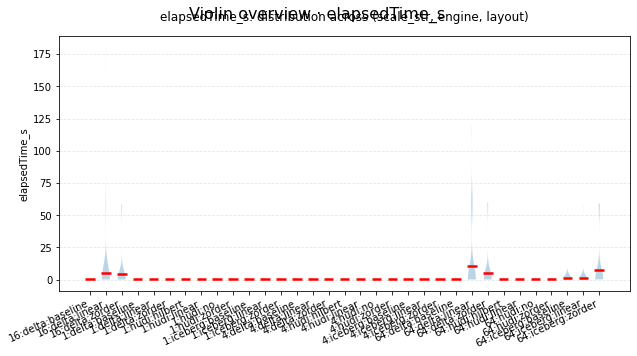

In [6]:
# Optional: violin overview combining all scales (single figure)
if metrics_present:
    combined = pd.concat(scale_frames.values(), ignore_index=True)
    combined["scale_str"] = combined["scale"].astype(str)
    metric = metrics_present[0]
    fig = plot_violin(
        combined,
        metric=metric,
        group_cols=("scale_str", "engine", "layout"),
    )
    fig.suptitle(f"Violin overview · {metric}", fontsize=16)
    savefig_multi(fig, OUTPUT_ROOT / f"overview_violin_{metric}")
else:
    print("Skipping violin overview: no metrics present.")


## Aggregated Views by Query and Scale

To complement the per-scale/per-query plots, the cells below build tidy summary
Tables and heatmaps. Each section includes a brief explanation so you can decide
which view best answers a particular research question.


In [8]:
# --- Build summary tables with descriptive output
from IPython.display import display

combined_all = (pd.concat(scale_frames.values(), ignore_index=True)
                if scale_frames else pd.DataFrame())
if combined_all.empty:
    raise SystemExit("No data available for aggregated summaries. Run the earlier cells first.")

agg_metrics = [m for m in metrics_present if m in combined_all.columns]
if not agg_metrics:
    raise SystemExit("None of the candidate metrics exist in the combined DataFrame.")

summary_q_scale = (
    combined_all
    .groupby(['query', 'scale'], dropna=False)[agg_metrics]
    .mean()
    .reset_index()
    .sort_values(['query', 'scale'])
)

summary_scale_query = (
    combined_all
    .groupby(['scale', 'query'], dropna=False)[agg_metrics]
    .mean()
    .reset_index()
    .sort_values(['scale', 'query'])
)

print("Per query · per scale (first 20 rows):")
display(summary_q_scale.head(20).round(3))

print("Per scale · per query (first 20 rows):")
display(summary_scale_query.head(20).round(3))


Per query · per scale (first 20 rows):


,query,scale,elapsedTime_s,executorRunTime_s,executorCpuTime_s,bytesRead_ev,files_scanned
0,001_DATES_A.sql,1,0.459,3.993,3.668,21.300,10.800
1,001_DATES_A.sql,4,0.506,2.753,2.352,47.900,12.400
2,001_DATES_A.sql,16,0.350,3.282,2.591,321.333,30.000
3,001_DATES_A.sql,64,0.557,9.498,6.000,5502.400,43.800
4,001_DATES_A_SINGLE_RANGE.sql,1,0.404,3.508,3.273,34.300,17.600
5,001_DATES_A_SINGLE_RANGE.sql,4,0.420,2.452,2.047,54.000,19.600
6,001_DATES_A_SINGLE_RANGE.sql,16,0.381,5.635,4.758,191.000,54.000
7,001_DATES_A_SINGLE_RANGE.sql,64,0.556,10.044,6.264,3266.400,59.800
8,001_DATES_EQ_SINGLE.sql,1,0.338,0.395,0.245,4.000,2.000
9,001_DATES_EQ_SINGLE.sql,4,0.362,0.721,0.489,16.900,2.400


Per scale · per query (first 20 rows):


,scale,query,elapsedTime_s,executorRunTime_s,executorCpuTime_s,bytesRead_ev,files_scanned
0,1,001_DATES_A.sql,0.459,3.993,3.668,21.3,10.8
1,1,001_DATES_A_SINGLE_RANGE.sql,0.404,3.508,3.273,34.3,17.6
2,1,001_DATES_EQ_SINGLE.sql,0.338,0.395,0.245,4.0,2.0
3,1,001_DATES_IN_MULTI.sql,0.376,1.951,0.638,15.3,3.6
4,1,001_GBY_MODE_HAVING_COUNT.sql,0.398,1.264,0.912,30.4,0.0
5,1,001_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,0.366,2.696,1.335,238.6,0.0
6,1,001_QUANTITY_DISCOUNT_BOX_WIDE.sql,0.431,3.584,1.005,381.1,0.0
7,1,002_DATES_A.sql,0.318,1.874,1.833,26.9,10.2
8,1,002_DATES_A_SINGLE_RANGE.sql,0.288,3.405,3.232,40.6,20.6
9,1,002_DATES_EQ_SINGLE.sql,0.247,0.213,0.216,3.7,2.0


### Pivoted tables

For a compact view, the next cell pivots the summaries so you can quickly see
how a metric changes when fixing either the query or the scale. Each table shows
the mean value per metric; blank cells indicate that a specific `(query, scale)`
combination is missing from the latest-results snapshot.


In [10]:
# --- Pivot tables by metric for quick inspection
for metric in agg_metrics:
    print(f"Metric: {metric} · Query vs Scale")
    pivot_q = summary_q_scale.pivot_table(index='query', columns='scale', values=metric)
    display(pivot_q.round(3))

    print(f"Metric: {metric} · Scale vs Query")
    pivot_s = summary_scale_query.pivot_table(index='scale', columns='query', values=metric)
    display(pivot_s.round(3))


Metric: elapsedTime_s · Query vs Scale


scale,1,4,16,64
query,,,,
001_DATES_A.sql,0.459,0.506,0.350,0.557
001_DATES_A_SINGLE_RANGE.sql,0.404,0.420,0.381,0.556
001_DATES_EQ_SINGLE.sql,0.338,0.362,0.262,6.185
001_DATES_IN_MULTI.sql,0.376,0.428,19.812,0.841
001_GBY_MODE_HAVING_COUNT.sql,0.398,0.438,18.913,0.828
...,...,...,...,...
010_DATES_EQ_SINGLE.sql,0.147,0.190,0.145,6.158
010_DATES_IN_MULTI.sql,0.234,0.289,60.225,0.519
010_GBY_MODE_HAVING_COUNT.sql,0.216,0.251,18.966,0.590


Metric: elapsedTime_s · Scale vs Query


query,001_DATES_A.sql,001_DATES_A_SINGLE_RANGE.sql,001_DATES_EQ_SINGLE.sql,001_DATES_IN_MULTI.sql,001_GBY_MODE_HAVING_COUNT.sql,001_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,001_QUANTITY_DISCOUNT_BOX_WIDE.sql,002_DATES_A.sql,002_DATES_A_SINGLE_RANGE.sql,002_DATES_EQ_SINGLE.sql,...,009_GBY_MODE_HAVING_COUNT.sql,009_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,009_QUANTITY_DISCOUNT_BOX_WIDE.sql,010_DATES_A.sql,010_DATES_A_SINGLE_RANGE.sql,010_DATES_EQ_SINGLE.sql,010_DATES_IN_MULTI.sql,010_GBY_MODE_HAVING_COUNT.sql,010_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,010_QUANTITY_DISCOUNT_BOX_WIDE.sql
scale,,,,,,,,,,,,,,,,,,,,,
1,0.459,0.404,0.338,0.376,0.398,0.366,0.431,0.318,0.288,0.247,...,0.210,0.239,0.259,0.269,0.218,0.147,0.234,0.216,0.236,0.238
4,0.506,0.420,0.362,0.428,0.438,0.450,0.436,0.510,0.325,0.272,...,0.275,0.298,0.291,0.382,0.225,0.190,0.289,0.251,0.306,0.289
16,0.350,0.381,0.262,19.812,18.913,0.651,0.467,0.413,0.266,0.177,...,19.573,0.421,0.291,0.178,0.468,0.145,60.225,18.966,0.411,0.287
64,0.557,0.556,6.185,0.841,0.828,18.982,0.883,0.488,6.004,6.200,...,0.471,12.516,0.630,0.320,0.266,6.158,0.519,0.590,6.798,0.623


Metric: executorRunTime_s · Query vs Scale


scale,1,4,16,64
query,,,,
001_DATES_A.sql,3.993,2.753,3.282,9.498
001_DATES_A_SINGLE_RANGE.sql,3.508,2.452,5.635,10.044
001_DATES_EQ_SINGLE.sql,0.395,0.721,1.407,132.159
001_DATES_IN_MULTI.sql,1.951,2.533,512.862,31.381
001_GBY_MODE_HAVING_COUNT.sql,1.264,1.781,486.231,19.324
...,...,...,...,...
010_DATES_EQ_SINGLE.sql,0.133,0.408,0.481,2.890
010_DATES_IN_MULTI.sql,2.278,3.013,3044.445,14.357
010_GBY_MODE_HAVING_COUNT.sql,0.647,1.045,565.143,14.909


Metric: executorRunTime_s · Scale vs Query


query,001_DATES_A.sql,001_DATES_A_SINGLE_RANGE.sql,001_DATES_EQ_SINGLE.sql,001_DATES_IN_MULTI.sql,001_GBY_MODE_HAVING_COUNT.sql,001_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,001_QUANTITY_DISCOUNT_BOX_WIDE.sql,002_DATES_A.sql,002_DATES_A_SINGLE_RANGE.sql,002_DATES_EQ_SINGLE.sql,...,009_GBY_MODE_HAVING_COUNT.sql,009_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,009_QUANTITY_DISCOUNT_BOX_WIDE.sql,010_DATES_A.sql,010_DATES_A_SINGLE_RANGE.sql,010_DATES_EQ_SINGLE.sql,010_DATES_IN_MULTI.sql,010_GBY_MODE_HAVING_COUNT.sql,010_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,010_QUANTITY_DISCOUNT_BOX_WIDE.sql
scale,,,,,,,,,,,,,,,,,,,,,
1,3.993,3.508,0.395,1.951,1.264,2.696,3.584,1.874,3.405,0.213,...,0.654,2.235,2.904,3.607,3.374,0.133,2.278,0.647,2.184,2.378
4,2.753,2.452,0.721,2.533,1.781,5.661,4.787,9.183,2.665,0.623,...,1.048,4.042,4.067,2.998,0.671,0.408,3.013,1.045,4.181,4.037
16,3.282,5.635,1.407,512.862,486.231,22.116,11.043,8.065,3.324,0.509,...,544.580,13.143,8.349,1.277,16.247,0.481,3044.445,565.143,12.987,7.360
64,9.498,10.044,132.159,31.381,19.324,787.486,31.231,11.837,16.506,3.916,...,12.843,165.132,24.450,7.047,4.600,2.890,14.357,14.909,50.348,23.698


Metric: executorCpuTime_s · Query vs Scale


scale,1,4,16,64
query,,,,
001_DATES_A.sql,3.668,2.352,2.591,6.000
001_DATES_A_SINGLE_RANGE.sql,3.273,2.047,4.758,6.264
001_DATES_EQ_SINGLE.sql,0.245,0.489,0.830,2.910
001_DATES_IN_MULTI.sql,0.638,1.692,1.474,3.655
001_GBY_MODE_HAVING_COUNT.sql,0.912,1.443,3.136,13.572
...,...,...,...,...
010_DATES_EQ_SINGLE.sql,0.137,0.408,0.322,2.161
010_DATES_IN_MULTI.sql,0.699,1.604,1.345,4.862
010_GBY_MODE_HAVING_COUNT.sql,0.510,0.857,3.558,13.259


Metric: executorCpuTime_s · Scale vs Query


query,001_DATES_A.sql,001_DATES_A_SINGLE_RANGE.sql,001_DATES_EQ_SINGLE.sql,001_DATES_IN_MULTI.sql,001_GBY_MODE_HAVING_COUNT.sql,001_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,001_QUANTITY_DISCOUNT_BOX_WIDE.sql,002_DATES_A.sql,002_DATES_A_SINGLE_RANGE.sql,002_DATES_EQ_SINGLE.sql,...,009_GBY_MODE_HAVING_COUNT.sql,009_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,009_QUANTITY_DISCOUNT_BOX_WIDE.sql,010_DATES_A.sql,010_DATES_A_SINGLE_RANGE.sql,010_DATES_EQ_SINGLE.sql,010_DATES_IN_MULTI.sql,010_GBY_MODE_HAVING_COUNT.sql,010_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,010_QUANTITY_DISCOUNT_BOX_WIDE.sql
scale,,,,,,,,,,,,,,,,,,,,,
1,3.668,3.273,0.245,0.638,0.912,1.335,1.005,1.833,3.232,0.216,...,0.429,1.028,0.724,3.593,3.332,0.137,0.699,0.510,1.018,0.729
4,2.352,2.047,0.489,1.692,1.443,3.743,2.268,9.128,2.430,0.601,...,0.899,3.047,1.610,2.961,0.592,0.408,1.604,0.857,3.026,1.674
16,2.591,4.758,0.830,1.474,3.136,12.295,3.824,6.902,2.735,0.413,...,2.513,11.724,3.419,1.005,15.992,0.322,1.345,3.558,11.406,3.446
64,6.000,6.264,2.910,3.655,13.572,46.783,18.640,8.582,3.569,2.516,...,10.582,44.650,18.987,5.036,3.335,2.161,4.862,13.259,44.582,20.212


Metric: bytesRead_ev · Query vs Scale


scale,1,4,16,64
query,,,,
001_DATES_A.sql,21.3,47.9,321.333,5502.4
001_DATES_A_SINGLE_RANGE.sql,34.3,54.0,191.000,3266.4
001_DATES_EQ_SINGLE.sql,4.0,16.9,13.000,3000.5
001_DATES_IN_MULTI.sql,15.3,36.4,82.333,3086.6
001_GBY_MODE_HAVING_COUNT.sql,30.4,79.1,167.333,12403.4
...,...,...,...,...
010_DATES_EQ_SINGLE.sql,2.6,9.3,13.000,2406.6
010_DATES_IN_MULTI.sql,27.1,79.0,118.000,12149.9
010_GBY_MODE_HAVING_COUNT.sql,38.5,91.9,249.667,12889.9


Metric: bytesRead_ev · Scale vs Query


query,001_DATES_A.sql,001_DATES_A_SINGLE_RANGE.sql,001_DATES_EQ_SINGLE.sql,001_DATES_IN_MULTI.sql,001_GBY_MODE_HAVING_COUNT.sql,001_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,001_QUANTITY_DISCOUNT_BOX_WIDE.sql,002_DATES_A.sql,002_DATES_A_SINGLE_RANGE.sql,002_DATES_EQ_SINGLE.sql,...,009_GBY_MODE_HAVING_COUNT.sql,009_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,009_QUANTITY_DISCOUNT_BOX_WIDE.sql,010_DATES_A.sql,010_DATES_A_SINGLE_RANGE.sql,010_DATES_EQ_SINGLE.sql,010_DATES_IN_MULTI.sql,010_GBY_MODE_HAVING_COUNT.sql,010_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,010_QUANTITY_DISCOUNT_BOX_WIDE.sql
scale,,,,,,,,,,,,,,,,,,,,,
1,21.300,34.3,4.0,15.300,30.400,238.600,381.100,26.900,40.6,3.7,...,43.0,242.600,366.700,21.200,18.8,2.6,27.1,38.500,245.600,390.700
4,47.900,54.0,16.9,36.400,79.100,1137.700,678.800,80.200,63.0,11.6,...,74.3,1101.900,679.000,48.400,34.4,9.3,79.0,91.900,1117.000,677.300
16,321.333,191.0,13.0,82.333,167.333,10164.667,3393.333,165.667,196.0,13.0,...,295.0,9943.333,3405.333,307.667,136.0,13.0,118.0,249.667,9907.333,3429.333
64,5502.400,3266.4,3000.5,3086.600,12403.400,115781.300,30911.200,18226.100,3417.0,2306.7,...,4191.2,115763.500,30881.800,5514.600,3207.0,2406.6,12149.9,12889.900,115720.300,30894.100


Metric: files_scanned · Query vs Scale


scale,1,4,16,64
query,,,,
001_DATES_A.sql,10.8,12.4,30.000,43.8
001_DATES_A_SINGLE_RANGE.sql,17.6,19.6,54.000,59.8
001_DATES_EQ_SINGLE.sql,2.0,2.4,2.000,23.2
001_DATES_IN_MULTI.sql,3.6,5.8,7.333,32.5
001_GBY_MODE_HAVING_COUNT.sql,0.0,0.0,0.000,0.0
...,...,...,...,...
010_DATES_EQ_SINGLE.sql,1.1,1.5,1.667,22.9
010_DATES_IN_MULTI.sql,4.6,6.3,7.667,52.5
010_GBY_MODE_HAVING_COUNT.sql,0.0,0.0,0.000,0.0


Metric: files_scanned · Scale vs Query


query,001_DATES_A.sql,001_DATES_A_SINGLE_RANGE.sql,001_DATES_EQ_SINGLE.sql,001_DATES_IN_MULTI.sql,001_GBY_MODE_HAVING_COUNT.sql,001_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,001_QUANTITY_DISCOUNT_BOX_WIDE.sql,002_DATES_A.sql,002_DATES_A_SINGLE_RANGE.sql,002_DATES_EQ_SINGLE.sql,...,009_GBY_MODE_HAVING_COUNT.sql,009_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,009_QUANTITY_DISCOUNT_BOX_WIDE.sql,010_DATES_A.sql,010_DATES_A_SINGLE_RANGE.sql,010_DATES_EQ_SINGLE.sql,010_DATES_IN_MULTI.sql,010_GBY_MODE_HAVING_COUNT.sql,010_GBY_SHIPYEAR_HAVING_SUM_CNT.sql,010_QUANTITY_DISCOUNT_BOX_WIDE.sql
scale,,,,,,,,,,,,,,,,,,,,,
1,10.8,17.6,2.0,3.600,0.0,0.0,0.0,10.200,20.600,2.0,...,0.0,0.0,0.0,10.800,8.200,1.100,4.600,0.0,0.0,0.0
4,12.4,19.6,2.4,5.800,0.0,0.0,0.0,11.300,22.800,2.4,...,0.0,0.0,0.0,12.400,9.500,1.500,6.300,0.0,0.0,0.0
16,30.0,54.0,2.0,7.333,0.0,0.0,0.0,24.667,63.667,2.0,...,0.0,0.0,0.0,32.667,23.667,1.667,7.667,0.0,0.0,0.0
64,43.8,59.8,23.2,32.500,0.0,0.0,0.0,64.800,69.900,23.2,...,0.0,0.0,0.0,46.500,47.700,22.900,52.500,0.0,0.0,0.0


### Heatmaps

Heatmaps provide a visual snapshot of the pivoted tables above. Darker colours
represent larger metric values. Each cell is annotated with the metric mean.
Figures are saved to `viz_out_results/tpch_overall/heatmap_*` for use outside the
notebook.


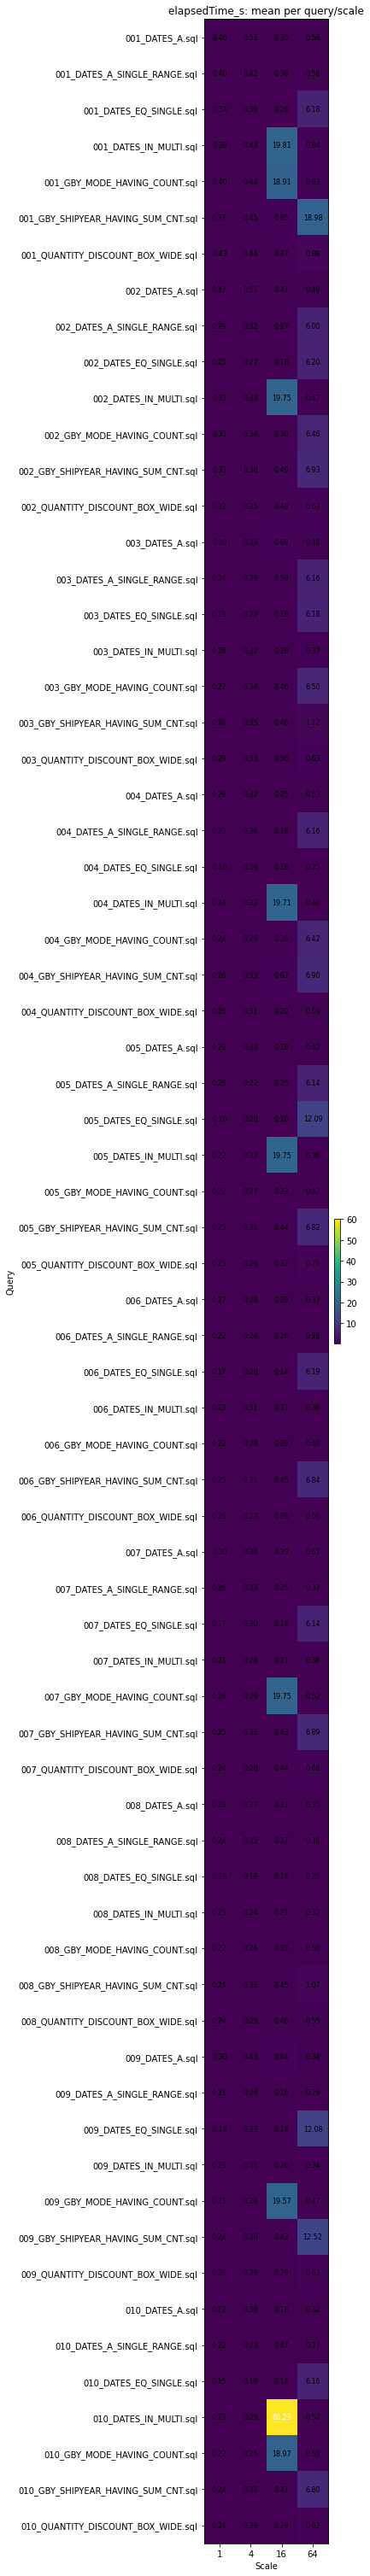

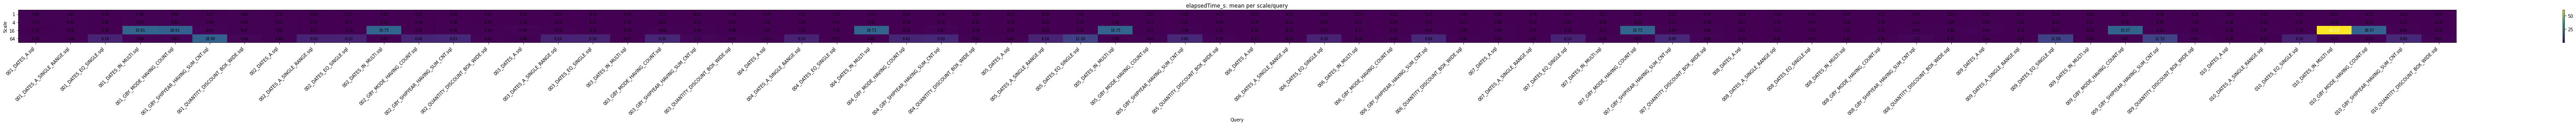

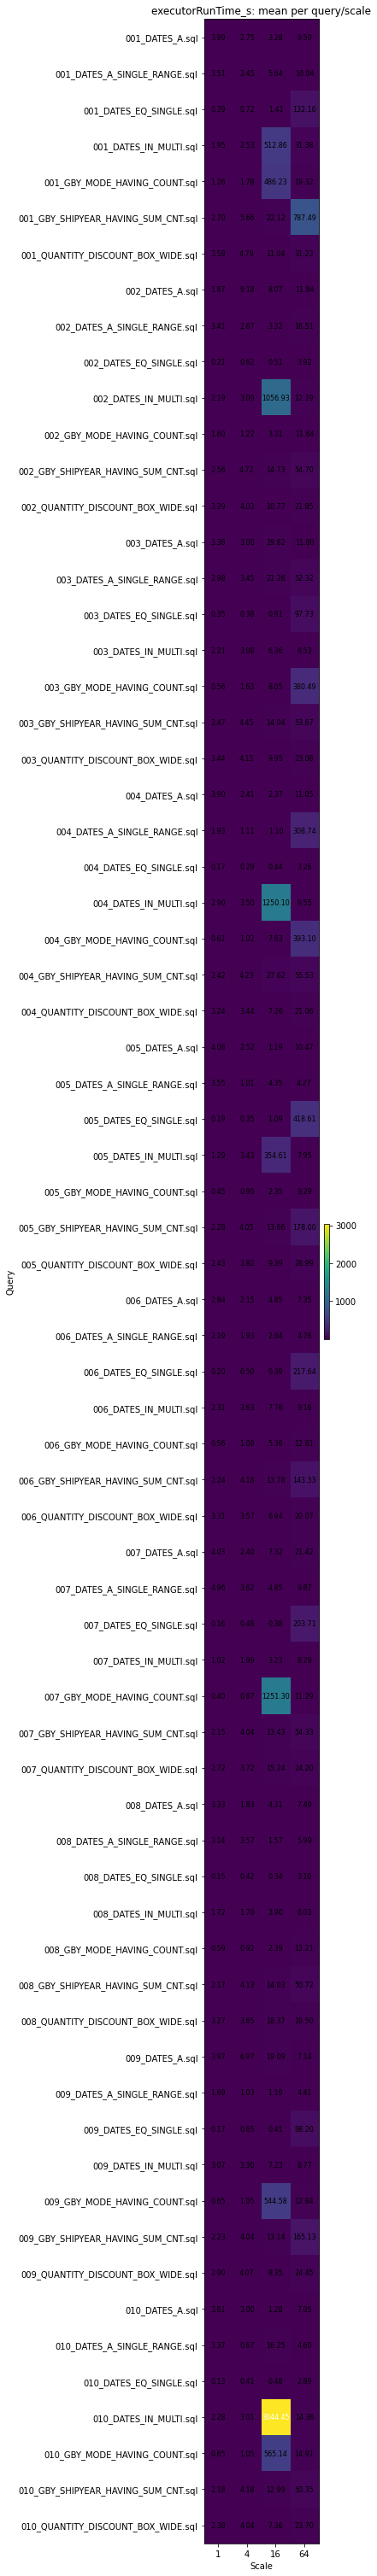

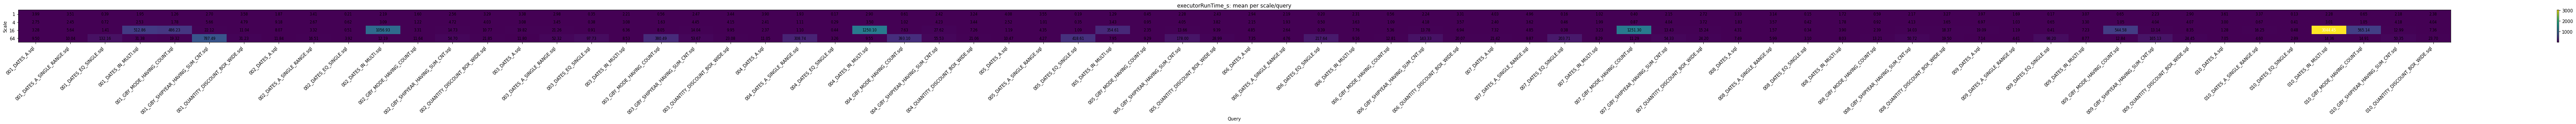

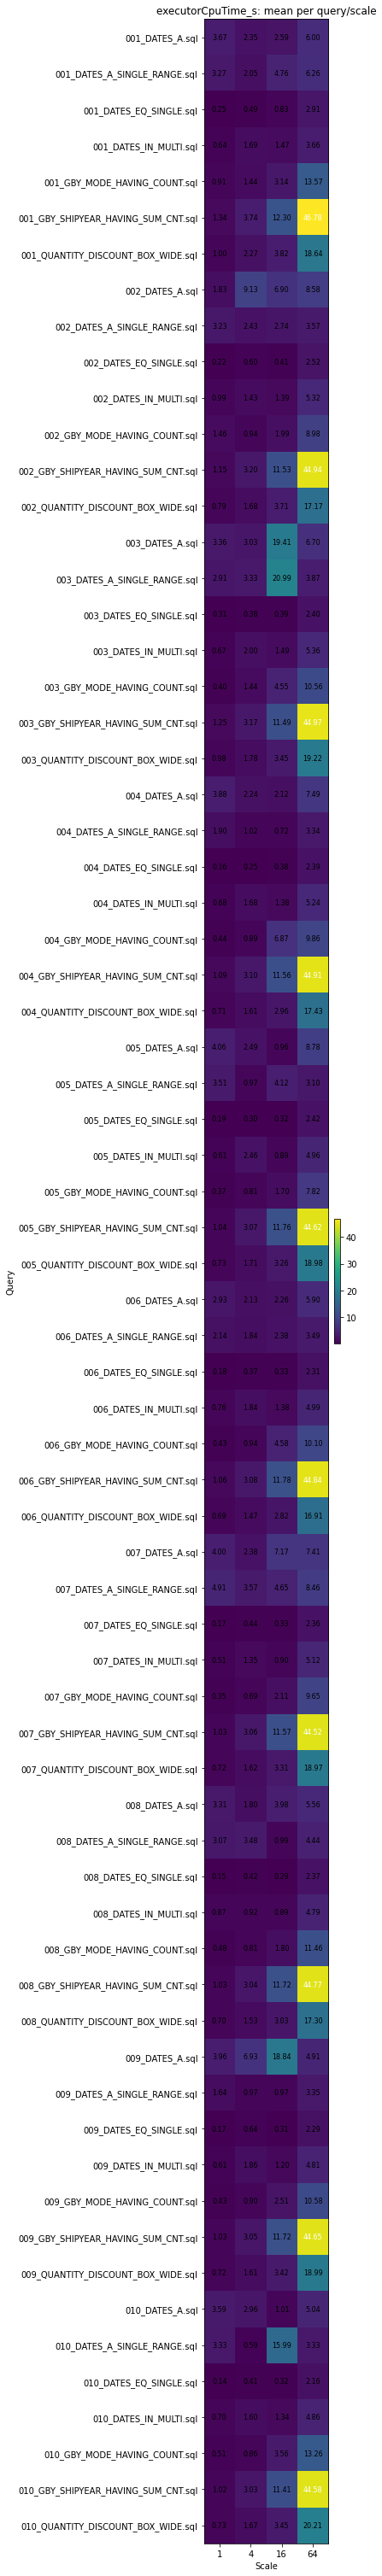

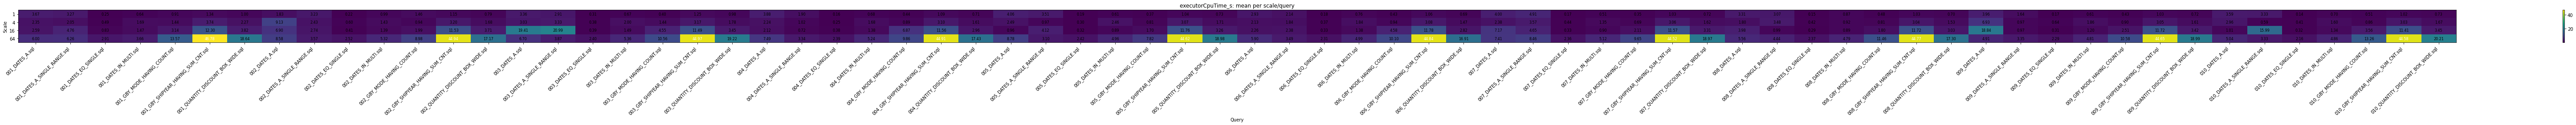

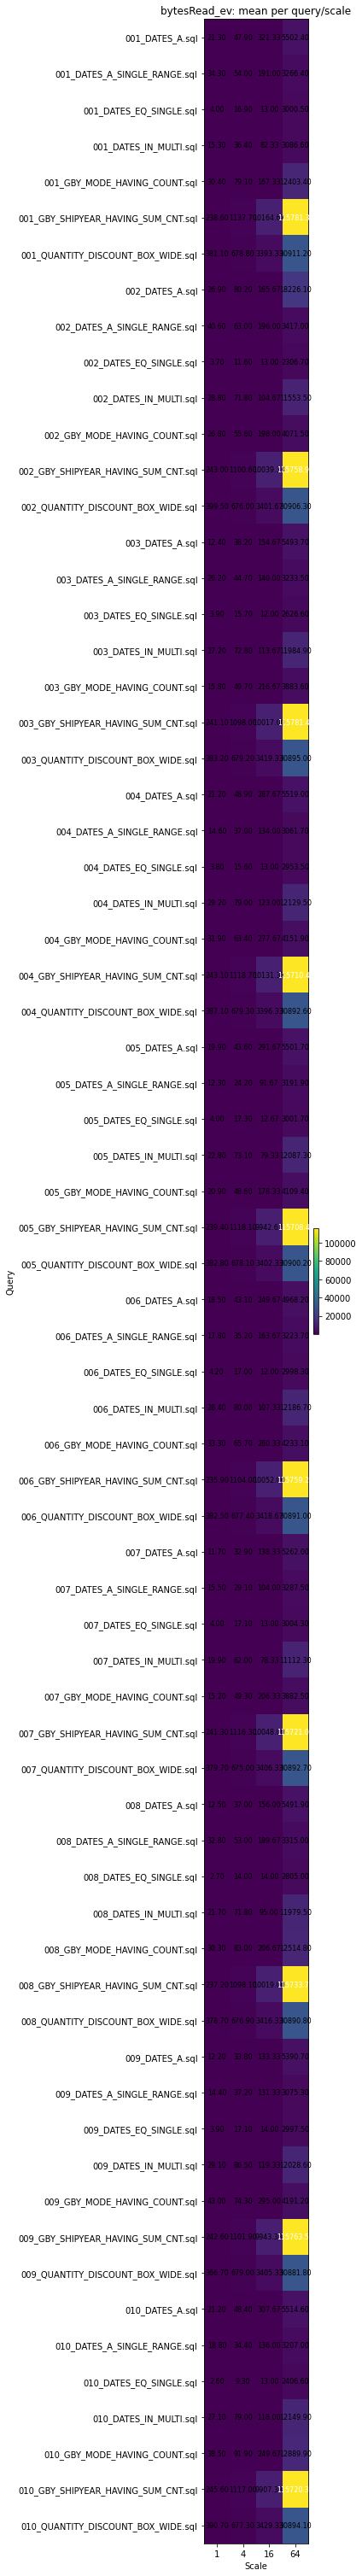

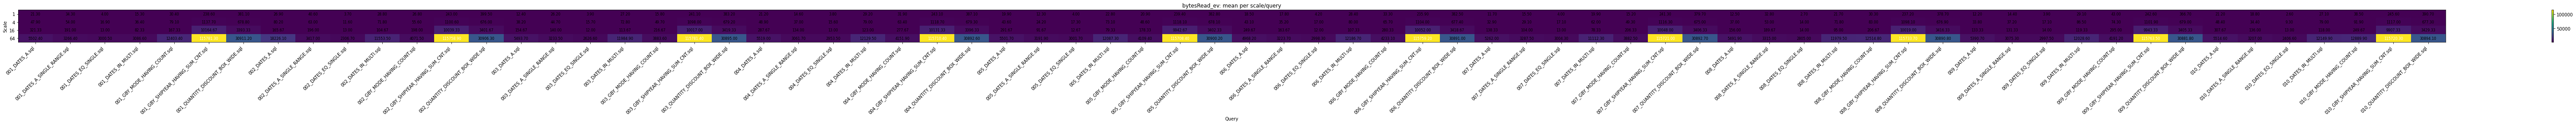

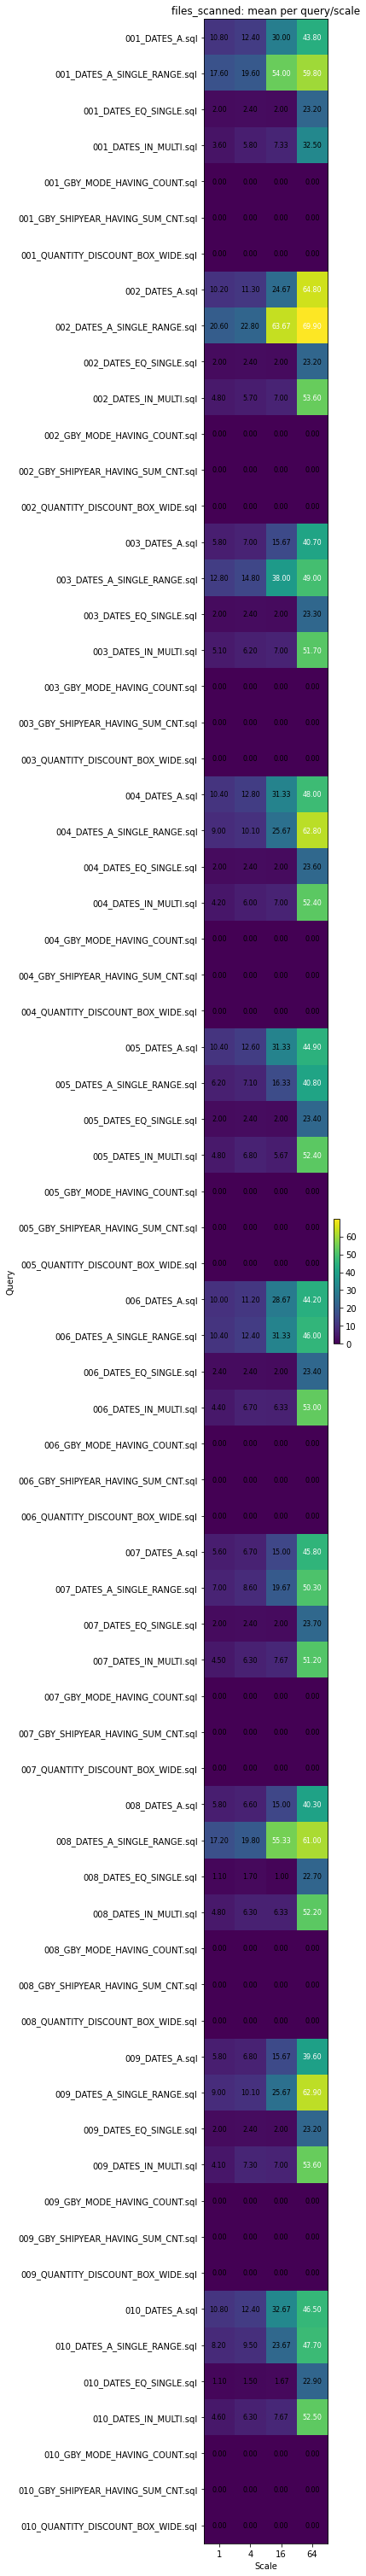

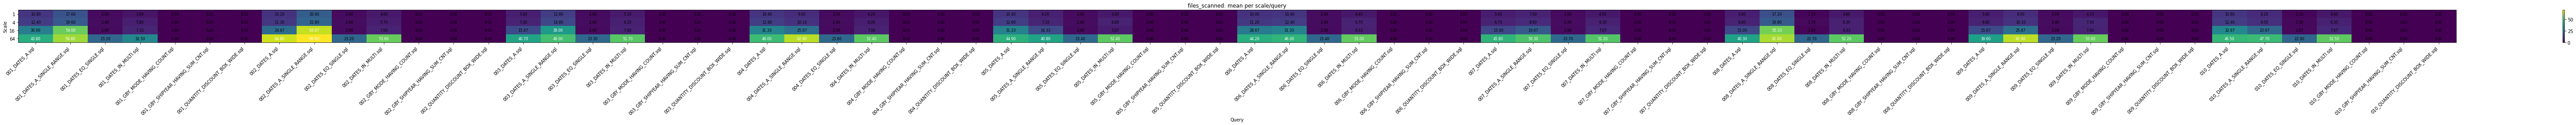

In [11]:
# --- Heatmaps with dynamic sizing and annotations
import numpy as np
import matplotlib.pyplot as plt

for metric in agg_metrics:
    pivot_q = summary_q_scale.pivot_table(index='query', columns='scale', values=metric)
    if not pivot_q.empty:
        fig_h = max(4, 0.6 * len(pivot_q))
        fig_w = max(6, 1.2 * len(pivot_q.columns))
        fig, ax = plt.subplots(figsize=(fig_w, fig_h))
        im = ax.imshow(pivot_q.values, cmap='viridis', aspect='auto')
        ax.set_xticks(range(len(pivot_q.columns)))
        ax.set_xticklabels(pivot_q.columns)
        ax.set_yticks(range(len(pivot_q.index)))
        ax.set_yticklabels(pivot_q.index)
        ax.set_xlabel('Scale')
        ax.set_ylabel('Query')
        ax.set_title(f'{metric}: mean per query/scale')
        vmax = np.nanmax(pivot_q.values)
        vmin = np.nanmin(pivot_q.values)
        threshold = vmin + (vmax - vmin) / 2 if np.isfinite(vmin) and np.isfinite(vmax) else 0
        for (i, j), val in np.ndenumerate(pivot_q.values):
            if np.isnan(val):
                continue
            color = 'white' if val > threshold else 'black'
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=8)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        fig.tight_layout()
        savefig_multi(fig, OUTPUT_ROOT / f'heatmap_query_scale_{metric}')
        plt.show()

    pivot_s = summary_scale_query.pivot_table(index='scale', columns='query', values=metric)
    if not pivot_s.empty:
        fig_h = max(4, 0.6 * len(pivot_s))
        fig_w = max(6, 1.2 * len(pivot_s.columns))
        fig, ax = plt.subplots(figsize=(fig_w, fig_h))
        im = ax.imshow(pivot_s.values, cmap='viridis', aspect='auto')
        ax.set_xticks(range(len(pivot_s.columns)))
        ax.set_xticklabels(pivot_s.columns, rotation=45, ha='right')
        ax.set_yticks(range(len(pivot_s.index)))
        ax.set_yticklabels(pivot_s.index)
        ax.set_xlabel('Query')
        ax.set_ylabel('Scale')
        ax.set_title(f'{metric}: mean per scale/query')
        vmax = np.nanmax(pivot_s.values)
        vmin = np.nanmin(pivot_s.values)
        threshold = vmin + (vmax - vmin) / 2 if np.isfinite(vmin) and np.isfinite(vmax) else 0
        for (i, j), val in np.ndenumerate(pivot_s.values):
            if np.isnan(val):
                continue
            color = 'white' if val > threshold else 'black'
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=8)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        fig.tight_layout()
        savefig_multi(fig, OUTPUT_ROOT / f'heatmap_scale_query_{metric}')
        plt.show()
